Phoneme Extraction from Speech Signals

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [ ]:
# Path to speech file in Google Drive
audio_path = "/content/drive/MyDrive/Colab Notebooks/Speech Processing/Lab2/LJ050-0274.wav"

# Install torchcodec if it's missing (required by torchaudio.load in newer versions)
!pip install torchcodec

# Load audio
waveform, sample_rate = torchaudio.load(audio_path)

# Convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Resample to 16 kHz
target_sr = 16000
if sample_rate != target_sr:
    resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
    waveform = resampler(waveform)
    sample_rate = target_sr

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)


Waveform shape: torch.Size([1, 72003])
Sample rate: 16000


In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
# Prepare input
input_values = processor(
    waveform.squeeze().numpy(),
    sampling_rate=sample_rate,
    return_tensors="pt"
).input_values

# Forward pass
with torch.no_grad():
    logits = model(input_values).logits

# Token prediction
predicted_ids = torch.argmax(logits, dim=-1)

# Decode
recognized_tokens = processor.decode(predicted_ids[0])
print("\nRecognized Phoneme / Token Sequence:")
print(recognized_tokens)


Recognized Phoneme / Token Sequence:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED


In [ ]:
tokens = predicted_ids[0].cpu().numpy()
num_frames = logits.shape[1]

signal_duration = waveform.shape[1] / sample_rate
time_per_frame = signal_duration / num_frames

phoneme_intervals = []

prev_token = int(tokens[0])
start_frame = 0

for i in range(1, len(tokens)):
    current_token = int(tokens[i])

    if current_token != prev_token:
        start_time = start_frame * time_per_frame
        end_time = i * time_per_frame

        # ✅ FIX: wrap token ID inside a list
        label = processor.tokenizer.convert_ids_to_tokens([prev_token])[0]

        phoneme_intervals.append((label, start_time, end_time))

        start_frame = i
        prev_token = current_token

# Add last phoneme
label = processor.tokenizer.convert_ids_to_tokens([prev_token])[0]
phoneme_intervals.append((label, start_frame * time_per_frame, signal_duration))

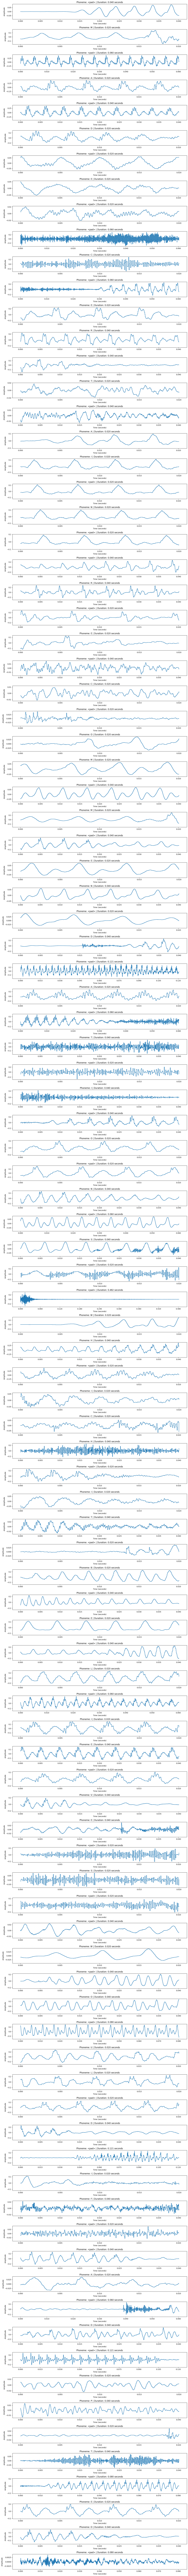

In [ ]:
valid_phonemes = [
    (label, s, e) for label, s, e in phoneme_intervals
    if label != "|" and (e - s) > 0.02
]

plt.figure(figsize=(15, 2 * len(valid_phonemes)))

plot_idx = 1

for label, start_time, end_time in valid_phonemes:

    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)

    phoneme_waveform = waveform[:, start_sample:end_sample]
    duration = end_time - start_time

    plt.subplot(len(valid_phonemes), 1, plot_idx)
    librosa.display.waveshow(
        phoneme_waveform.squeeze().numpy(),
        sr=sample_rate
    )

    plt.title(f"Phoneme: {label} | Duration: {duration:.3f} seconds")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")

    plot_idx += 1

plt.tight_layout()
plt.show()

In [ ]:
print("\nPHONEME DURATION TABLE\n")
print("{:<10} {:<15} {:<15}".format("Phoneme", "Start Time (s)", "Duration (s)"))

for label, start_time, end_time in valid_phonemes:
    duration = end_time - start_time
    print("{:<10} {:<15.3f} {:<15.3f}".format(label, start_time, duration))


PHONEME DURATION TABLE

Phoneme    Start Time (s)  Duration (s)   
<pad>      0.000           0.040          
M          0.040           0.020          
<pad>      0.060           0.060          
A          0.121           0.020          
<pad>      0.141           0.040          
D          0.181           0.020          
<pad>      0.201           0.020          
E          0.221           0.020          
<pad>      0.241           0.020          
<pad>      0.321           0.060          
C          0.382           0.020          
<pad>      0.402           0.060          
E          0.462           0.020          
R          0.482           0.040          
<pad>      0.522           0.040          
T          0.563           0.020          
<pad>      0.583           0.040          
A          0.623           0.020          
I          0.643           0.020          
<pad>      0.663           0.020          
N          0.683           0.020          
<pad>      0.703           0.

In [ ]:
vowels = ['AA', 'AE', 'AH', 'AO', 'EH', 'ER', 'IH', 'IY', 'UH', 'UW']

print("\nINFERENCE ABOUT SOURCE OF SOUND\n")

for label, start_time, end_time in valid_phonemes:
    duration = end_time - start_time
    phoneme = label.replace("▁", "")

    if phoneme in vowels:
        source = "Voiced sound (vocal cord vibration)"
    else:
        source = "Unvoiced / plosive / fricative sound"

    print(f"Phoneme: {label:<4} | Duration: {duration:.3f} s | Source: {source}")


INFERENCE ABOUT SOURCE OF SOUND

Phoneme: <pad> | Duration: 0.040 s | Source: Unvoiced / plosive / fricative sound
Phoneme: M    | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: <pad> | Duration: 0.060 s | Source: Unvoiced / plosive / fricative sound
Phoneme: A    | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: <pad> | Duration: 0.040 s | Source: Unvoiced / plosive / fricative sound
Phoneme: D    | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: <pad> | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: E    | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: <pad> | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: <pad> | Duration: 0.060 s | Source: Unvoiced / plosive / fricative sound
Phoneme: C    | Duration: 0.020 s | Source: Unvoiced / plosive / fricative sound
Phoneme: <pad> | Duration: 0.060 s | Source: Unvoiced / plosive / fri